# Riemannian $\mathcal{GP}$ Geodesics

In [1]:
from jax import vmap

import jax.numpy as jnp

import numpy as np

from geometry.geodesics.riemannian import GradientDescent, JAXOptimization, ScipyOptimization, GEORCE

import os

import torch
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from geometry.manifolds.riemannian import GPRiemannian

from generate_data import generate_data

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-06-25 19:13:43.774886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

## Kernel

In [3]:
omega = 500.0
beta = 1.0
        
def k_fun(x,y, params=jnp.array([beta, omega])):
    
    beta = params[0]
    omega = params[1]

    x_diff = x-y

    return beta*jnp.exp(-omega*jnp.dot(x_diff, x_diff)/2)

def Dk_fun(x,y, params=jnp.array([beta, omega])):
    
    beta = params[0]
    omega = params[1]

    x_diff = y-x

    return omega*x_diff*k_fun(x,y,params)

def DDk_fun(x,y, params=jnp.array([beta, omega])):
    
    beta = params[0]
    omega = params[1]

    N = len(x)
    x_diff = (x-y).reshape(1,-1)

    return -omega*k_fun(x,y,params)*(x_diff.T.dot(x_diff)*omega-jnp.eye(N))

## $\mathcal{GP}$ for Rotated MNIST

In [4]:
if not os.path.exists('data/MNIST/'):
    generate_data("gp_mnist")

In [5]:
y_data = jnp.load('data/MNIST/y.npy')
X_data = jnp.load('data/MNIST/X.npy')

In [6]:
GPM = GPRiemannian(X_training = X_data,
                   y_training = y_data,
                   mu_fun = None,
                   k_fun = k_fun,
                   optimize_hyper_parameters=False,
                   sigma=0.0,
                   lr_rate=0.001,
                   optimizer=None,
                   max_iter=1000,
                   delta=1e-10,
                   kernel_params=jnp.array([beta, omega]),
                   Dk_fun=Dk_fun,
                   DDk_fun=DDk_fun,
                   DDDk_fun=None,
                   DDDDk_fun=None,
                   Dmu_fun=None,
                   DDmu_fun = None,
                   DDDmu_fun = None
                  )

### Plotting Estimates

In [7]:
data_post = vmap(lambda x: GPM.post_mom(x)[0])(X_data.T[::2])
mnist_data = torch.Tensor(np.array(data_post.reshape(-1,1,28,28)))
mnist_true = torch.Tensor(np.array(y_data.T[::2].reshape(-1,1,28,28)))

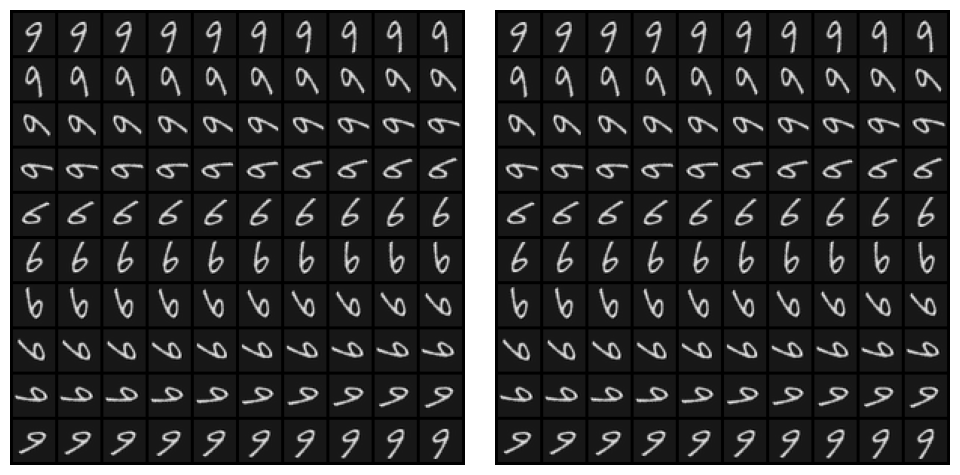

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax.imshow(np.transpose(vutils.make_grid(mnist_true.to('cpu'), padding=2, normalize=True, nrow=10).cpu(),(1,2,0)))
ax.set_axis_off()
ax = fig.add_subplot(122)
ax.imshow(np.transpose(vutils.make_grid(mnist_data.to('cpu'), padding=2, normalize=True, nrow=10).cpu(),(1,2,0)))
ax.set_axis_off()
fig.tight_layout()

plt.show()

### Geodesic Estimation

In [37]:
T = 10
max_iter = 100
mnist_z0, mnist_zT = X_data[:,0], X_data[:,20]

#### GEORCE

In [38]:
Geodesic = GEORCE(M=GPM,
                  init_fun=None,
                  T=T,
                  line_search_method="soft",
                  max_iter=max_iter,
                )
zt, grad, _ = Geodesic(mnist_z0,mnist_zT, "while")

In [39]:
georce_mnist_zt = zt
georce_mnist_xt = vmap(GPM.f)(georce_mnist_zt).reshape(-1,28,28,1)
georce_mnist_length = GPM.length(georce_mnist_zt)

init_mnist_zt = Geodesic.init_fun(mnist_z0,mnist_zT, T)
init_mnist_zt = jnp.vstack((mnist_z0, init_mnist_zt, mnist_zT))
init_mnist_xt = vmap(GPM.f)(init_mnist_zt).reshape(-1,28,28,1)
init_mnist_length = GPM.length(init_mnist_zt)

#### JAX

In [40]:
Geodesic = JAXOptimization(M = GPM,
                           init_fun=None,
                           lr_rate=0.001,
                           optimizer=None,
                           T=T,
                           max_iter=max_iter,
                          )
zt, grad, _ = Geodesic(mnist_z0,mnist_zT, "while")

In [41]:
jax_mnist_zt = zt
jax_mnist_xt = vmap(GPM.f)(jax_mnist_zt).reshape(-1,28,28,1)
jax_mnist_length = GPM.length(jax_mnist_zt)

#### Plotting

In [42]:
mnist_xt = jnp.stack((init_mnist_xt, georce_mnist_xt, jax_mnist_xt))
mnist_length = jnp.stack((init_mnist_length, georce_mnist_length, jax_mnist_length))
mnist_length = [f"Init: {init_mnist_length:.4f}", f"GEORCE: {georce_mnist_length:.4f}",
               f"ADAM: {jax_mnist_length:.4f}"]

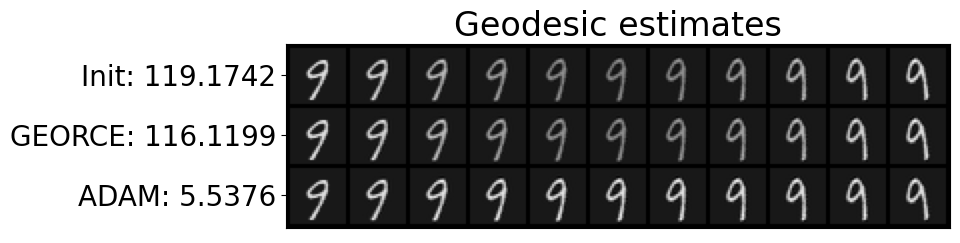

In [43]:
load_path = 'models/CelebA/'
names = ['geodesics1.pt', 'geodesics2.pt', 'geodesics3.pt']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title("Geodesic estimates")
img_height = 28+2
tick_list = [img_height/2, img_height/2+img_height, img_height/2+2*img_height]
tick_list_x = []
euc_length_x = []
mnist_xt = mnist_xt.reshape(-1,28,28,1)
for j in range(T+1):
    tick_list_x.append(img_height/2+j*img_height)
plot_val = torch.from_numpy(np.transpose(np.array(mnist_xt), (0,3,1,2)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(mnist_length)

fig.tight_layout()

plt.show()
#ax.set_xticks(tick_list_x)
#ax.set_xticklabels(euc_length_x) 